In [1]:
import numpy as np
import pandas as pd 
import cv2
import random
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
df = pd.read_csv("full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [4]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [5]:
df["right_cataract"][1:5]

1    0
2    0
3    0
4    0
Name: right_cataract, dtype: int64

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(cataract),len(normal))

594 500


In [11]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = r'C:\Users\ADNAN\Documents\Python programs\My programs\ANN\pr_img'
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))

        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [12]:
dataset = create_dataset(cataract,1)

100%|████████████████████████████████████████████████████████████████████████████████| 594/594 [00:06<00:00, 89.56it/s]


In [13]:
dataset = create_dataset(normal,0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.59it/s]


In [14]:
len(dataset)

1088

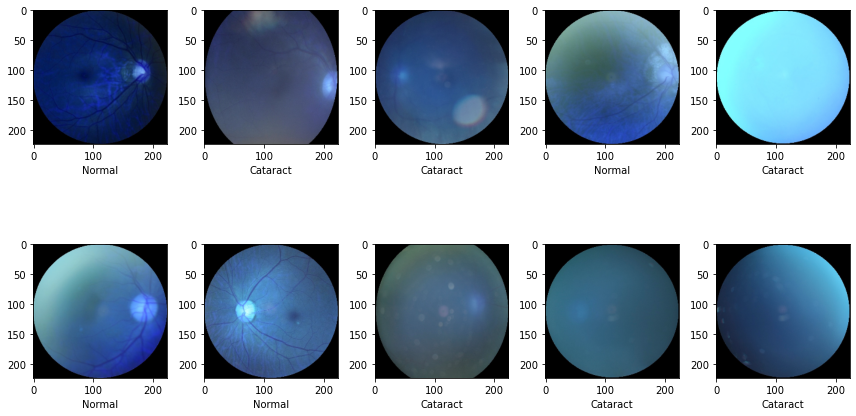

In [15]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()  

In [16]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [17]:
x.shape

(1088, 224, 224, 3)

In [18]:
x[1][223][223][0]

0

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (image_size,image_size,3), include_top = False, weights = 'imagenet')

In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
import tensorflow as tf 

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])


In [27]:
inc_history = model.fit(x_train,y_train, validation_data = (x_test,y_test), steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 72s 722ms/step - loss: 2.4653 - acc: 0.8952 - val_loss: 2.2688 - val_acc: 0.9037
Epoch 2/10
100/100 [==============================] - 72s 717ms/step - loss: 1.4782 - acc: 0.9231 - val_loss: 3.2642 - val_acc: 0.8578
Epoch 3/10
100/100 [==============================] - 72s 718ms/step - loss: 2.0909 - acc: 0.9175 - val_loss: 3.0007 - val_acc: 0.8624
Epoch 4/10
100/100 [==============================] - 231s 2s/step - loss: 1.8773 - acc: 0.9142 - val_loss: 2.0484 - val_acc: 0.9128
Epoch 5/10
100/100 [==============================] - 74s 737ms/step - loss: 1.2773 - acc: 0.9331 - val_loss: 2.1422 - val_acc: 0.9174
Epoch 6/10
100/100 [==============================] - 72s 723ms/step - loss: 1.9569 - acc: 0.9197 - val_loss: 2.2181 - val_acc: 0.8991
Epoch 7/10
100/100 [==============================] - 76s 759ms/step - loss: 1.2357 - acc: 0.9398 - val_loss: 3.0025 - val_acc: 0.9083
Epoch 8/10
100/100 [==============================] - 74s

In [28]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 6s 890ms/step - loss: 3.1493 - acc: 0.8624
loss: 3.1493020057678223
Accuracy: 0.8623853325843811


In [36]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")

In [37]:
accuracy_score(y_test,y_pred)

0.8623853211009175

In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       100
           1       0.97      0.77      0.86       118

    accuracy                           0.86       218
   macro avg       0.88      0.87      0.86       218
weighted avg       0.88      0.86      0.86       218



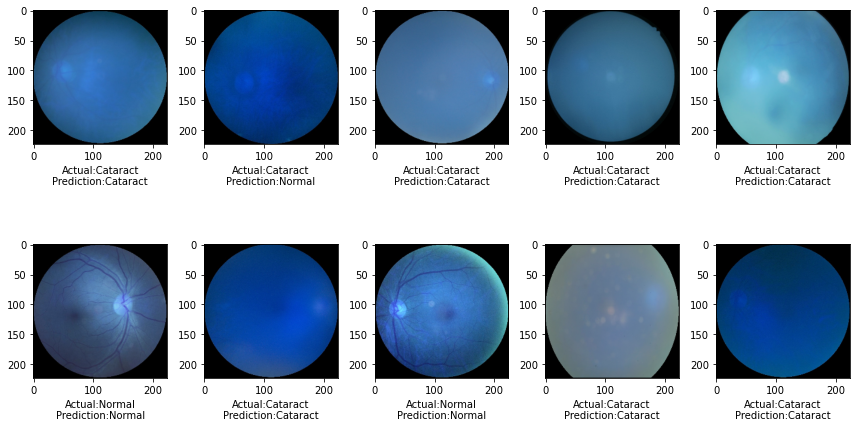

In [39]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 